## Introduction

This notebook shows the visualization of the coronavirus in country level. The purpose is to further analyze the behavior of the spread in the top countries where confirmed cases went up. We have to separate this to other notebooks because we will solve for the basic reproduction number of COVID-19 and compare it to other coronaviruses (our references were made in Python).

Using a mathematical epidemic model, this notebook will predict the number of cases infected with COVID-19.

 * Arrangement of dataset (All countries)
 * Trend analysis
 * Improvement of model (SIR, SIR-D)

Note: "Infected" means the currently infected cases. This can be calculated as "Confirmed" - "Deaths" - "Recovered"

### Visualizing COVID-19 in Country Level

In [45]:
raw = pd.read_csv("covid_19_data.csv", parse_dates = ['ObservationDate','Last Update'])

print (raw.shape)
print ('Last update: ' + str(raw.ObservationDate.max()))

(5632, 8)
Last update: 2020-03-14 00:00:00


In [46]:
checkdup = raw.groupby(['Country/Region','Province/State','ObservationDate']).count().iloc[:,0]
checkdup[checkdup>1]

Country/Region  Province/State  ObservationDate
Mainland China  Gansu           2020-03-11         2
                                2020-03-12         2
                Hebei           2020-03-11         2
                                2020-03-12         2
Name: SNo, dtype: int64

In [47]:
raw = raw.drop(['SNo', 'Last Update'], axis=1)
raw = raw.rename(columns={'Country/Region': 'Country', 'ObservationDate':'Date'})
# To check null values
raw.isnull().sum()

Date                 0
Province/State    2176
Country              0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [48]:
# Update for Mar 15 data to clean up data
raw.Country = raw.Country.str.replace('Hong Kong SAR', 'Hong Kong')
raw.Country = raw.Country.str.replace('Taipei and environs', 'Taiwan')
raw.Country = raw.Country.str.replace('Republic of Korea', 'South Korea')
raw.Country = raw.Country.str.replace('Viet Nam', 'Vietnam')
raw.Country = raw.Country.str.replace('occupied Palestinian territory', 'Palestine')
raw.Country = raw.Country.str.replace('Macao SAR', 'Macau')
raw.Country = raw.Country.str.replace('Russian Federation', 'Russia')
raw.Country = raw.Country.str.replace('Republic of Moldova', 'Moldova')
raw.Country = raw.Country.str.replace('Holy See', 'Vatican City')
raw.Country = raw.Country.str.replace('Iran \(Islamic Republic of\)', 'Iran')

In [49]:
daily = raw.sort_values(['Date','Country','Province/State'])

In [94]:
def get_place(row):
    if row['Country'] == 'Italy':
        return 'Italy'
    elif row['Country'] == 'Mainland China': 
        return 'China'
    elif row['Country'] == 'South Korea':
        return 'South Korea'
    elif row['Country'] == 'Iran': 
        return 'Iran'
    elif row['Country'] == 'Philippines':
        return 'Philippines'
    else: return 'Other Countries'
    
daily['segment'] = daily.apply(lambda row: get_place(row), axis=1)

### Latest Update

In [95]:
latest = daily[daily.Date == daily.Date.max()]

In [57]:
print ('Total confirmed cases: %.d' %np.sum(latest['Confirmed']))
print ('Total death cases: %.d' %np.sum(latest['Deaths']))
print ('Total recovered cases: %.d' %np.sum(latest['Recovered']))

Total confirmed cases: 156099
Total death cases: 5819
Total recovered cases: 72624


In [58]:
segment1 = latest.groupby('segment').sum()
segment1['Death Rate'] = segment1['Deaths'] / segment1['Confirmed'] * 100
segment1['Recovery Rate'] = segment1['Recovered'] / segment1['Confirmed'] * 100
segment1

,Confirmed,Deaths,Recovered,Death Rate,Recovery Rate
segment,,,,,
China,80977.0,3193.0,65660.0,3.943095,81.084752
Iran,12729.0,611.0,2959.0,4.800063,23.246131
Italy,21157.0,1441.0,1966.0,6.810985,9.292433
Other Countries,33039.0,494.0,1527.0,1.495203,4.621811
Philippines,111.0,8.0,2.0,7.207207,1.801802
South Korea,8086.0,72.0,510.0,0.890428,6.307198


In [69]:
daily2 = raw.sort_values(['Date','Country','Province/State'])

In [70]:
def get_place_2(row):
    if row['Province/State'] == 'Hubei':
        return 'Hubei PRC'
    elif row['Country'] == 'Mainland China': 
        return 'Others PRC'
    else: return 'World'
    
daily2['segment2'] = daily2.apply(lambda row: get_place_2(row), axis=1)

In [71]:
latest2 = daily2[daily2.Date == daily2.Date.max()]

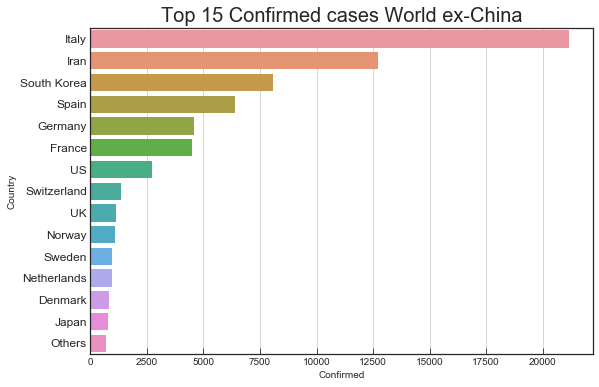

In [73]:
# Confirmed Cases World ex-China
worldstat = latest2[latest2.segment2=='World'].groupby('Country').sum()
_ = worldstat.sort_values('Confirmed', ascending=False).head(15)
c10 = _.index.tolist() # Will be used in later part
plt.figure(figsize=(9,6))
sns.barplot(_.Confirmed, _.index)
plt.title('Top 15 Confirmed cases World ex-China', size = 20)
plt.yticks(fontsize=12)
plt.grid(axis='x')
plt.show()

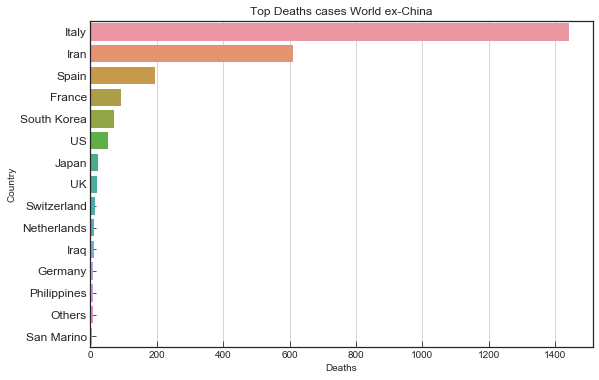

In [75]:
_ = worldstat.sort_values('Deaths', ascending=False).head(15)
_ = _[_.Deaths>0]
plt.figure(figsize=(9,6))
sns.barplot(_.Deaths, _.index)
plt.title('Top Deaths cases World ex-China')
plt.yticks(fontsize=12)
plt.grid(axis='x')
plt.show()

### Evolution of cases in Top Countries with Confirmed Cases and the Philippines

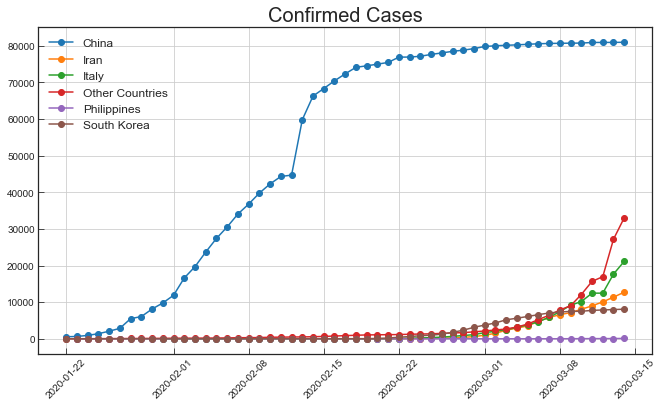

In [80]:
confirm = pd.pivot_table(daily.dropna(subset=['Confirmed']), index='Date', 
                         columns='segment', values='Confirmed', aggfunc=np.sum).fillna(method='ffill')
plt.figure(figsize=(11,6))
plt.plot(confirm, marker='o')
plt.title('Confirmed Cases', size = 20)
plt.legend(confirm.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Findings:

* There are much fewer new cases recently in China
* Cases outside China is growing exponentially

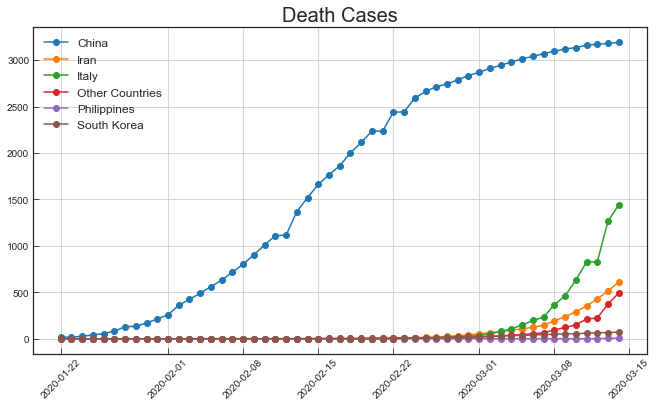

In [79]:
death = pd.pivot_table(daily.dropna(subset=['Deaths']), 
                         index='Date', columns='segment', values='Deaths', aggfunc=np.sum).fillna(method = 'ffill')
plt.figure(figsize=(11,6))
plt.plot(death, marker='o')
plt.title('Death Cases', size = 20)
plt.legend(death.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

A worrying sign is world death cases showed an exponential rising trend.

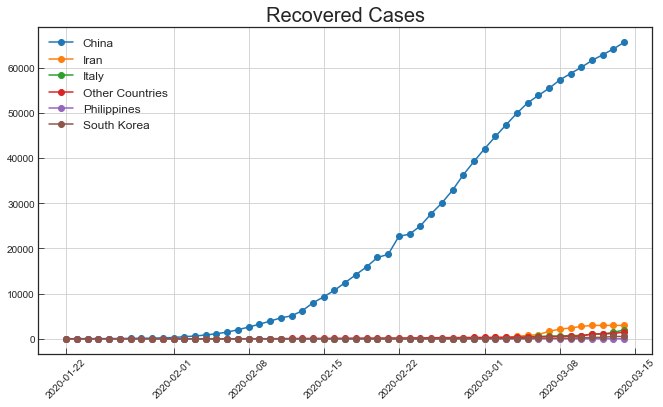

In [87]:
good = pd.pivot_table(daily.dropna(subset=['Recovered']), 
                         index='Date', columns='segment', values='Recovered', aggfunc=np.sum).fillna(method = 'ffill')
plt.figure(figsize=(11,6))
plt.plot(good, marker='o')
plt.title('Recovered Cases', size = 20)
plt.legend(good.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


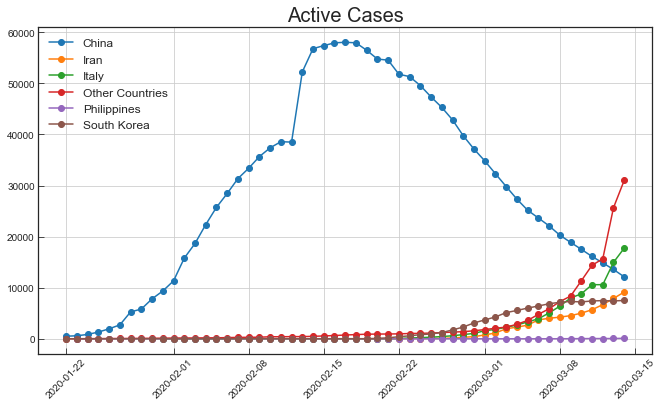

In [99]:
# Active case - confirmed minus deaths and recovered
daily['Active'] = daily['Confirmed'] - daily['Deaths'] - daily['Recovered']
active = pd.pivot_table(daily.dropna(subset=['Active']), 
                         index='Date', columns='segment', values='Active', aggfunc=np.sum).fillna(method = 'ffill')
plt.figure(figsize=(11,6))
plt.plot(active, marker='o')
plt.title('Active Cases', size = 20)
plt.legend(active.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [105]:
df = confirm.join(death, lsuffix='_confirm', rsuffix='_death')
df = df.join(good.add_suffix('_recover'))
df['China_death_rate'] = df['China_death']/df['China_confirm']
df['Italy_death_rate'] = df['Italy_death']/df['Italy_confirm']
df['Iran_rate'] = df['Iran_death']/df['Iran_confirm']
df['South_Korea_rate'] = df['South Korea_death']/df['South Korea_confirm']
df['Other Countries_rate'] = df['Other Countries_death']/df['Other Countries_confirm']
df['China_recover_rate'] = df['China_recover']/df['China_confirm']
df['Italy_recover_rate'] = df['Italy_recover']/df['Italy_confirm']
df['Iran_recover_rate'] = df['Iran_recover']/df['Iran_confirm']
df['South Korea_recover_rate'] = df['South Korea_recover']/df['South Korea_confirm']
df['Other Countries_recover_rate'] = df['Other Countries_recover']/df['Other Countries_confirm']

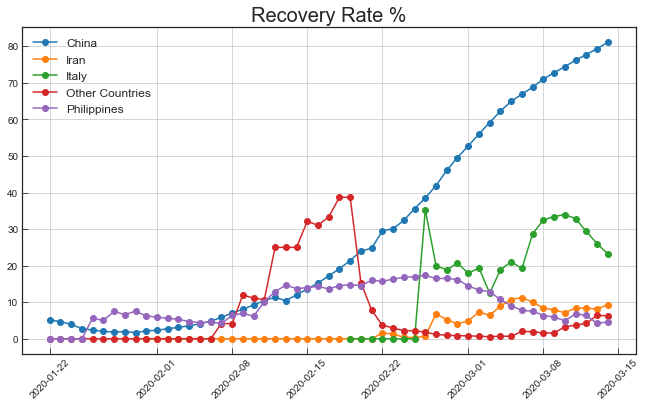

In [109]:
recover_rate = df[['China_recover_rate','Italy_recover_rate','Iran_recover_rate','South Korea_recover_rate','Other Countries_recover_rate']]*100
plt.figure(figsize=(11,6))
plt.plot(recover_rate, marker='o')
plt.title('Recovery Rate %', size = 20)
plt.legend(good.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

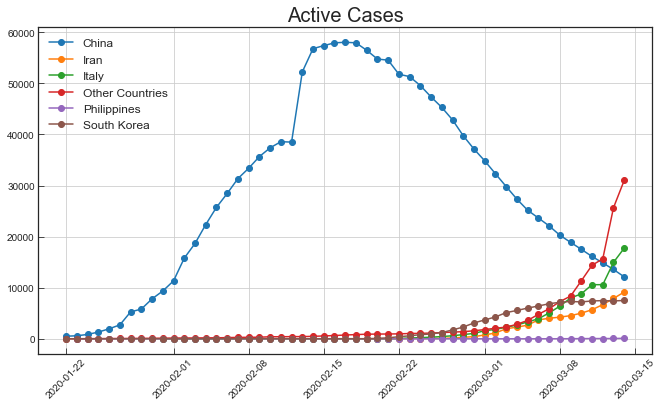

In [96]:
# Active case - confirmed minus deaths and recovered
daily['Active'] = daily['Confirmed'] - daily['Deaths'] - daily['Recovered']
active = pd.pivot_table(daily.dropna(subset=['Active']), 
                         index='Date', columns='segment', values='Active', aggfunc=np.sum).fillna(method = 'ffill')
plt.figure(figsize=(11,6))
plt.plot(active, marker='o')
plt.title('Active Cases', size = 20)
plt.legend(active.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

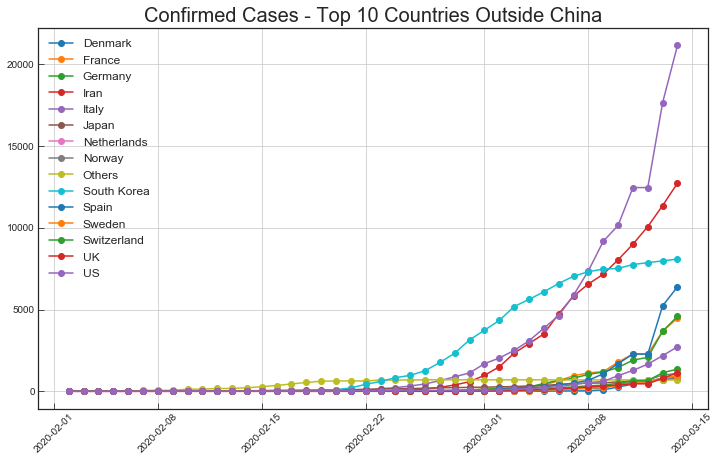

In [101]:
# Global ex-China - Top 10 countries
# Confirmed cases
c10cases = daily[daily['Country'].isin(c10)]
confirm_w = pd.pivot_table(c10cases.dropna(subset=['Confirmed']), index='Date', 
                         columns='Country', values='Confirmed', aggfunc=np.sum).fillna(method='ffill')
plt.figure(figsize=(12,7))
plt.plot(confirm_w[confirm_w.index>'2020-02-01'], marker='o')
plt.title('Confirmed Cases - Top 10 Countries Outside China', size = 20)
plt.legend(confirm_w.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Italy and Iran are countries that see exponential increase in cases. South Korea cases started to slow down.

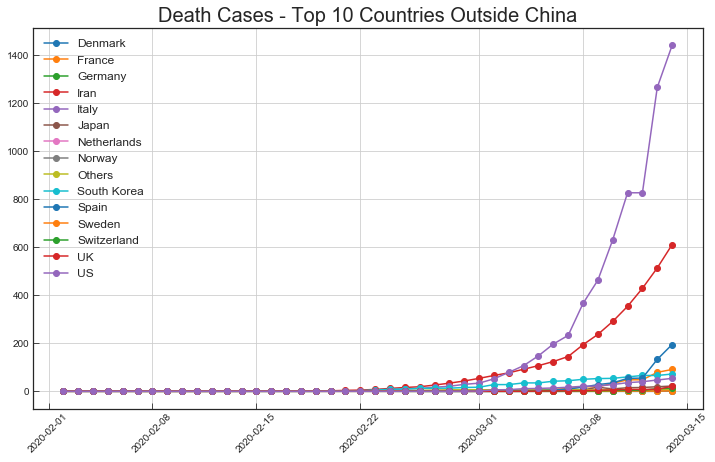

In [103]:
death_w = pd.pivot_table(c10cases.dropna(subset=['Deaths']), index='Date', 
                         columns='Country', values='Deaths', aggfunc=np.sum).fillna(method='ffill')
plt.figure(figsize=(12,7))
plt.plot(death_w[death_w.index>'2020-02-01'], marker='o')
plt.title('Death Cases - Top 10 Countries Outside China', size = 20)
plt.legend(death_w.columns, loc=2, fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

------------

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%H"
datetime.now().strftime(time_format)

'15Mar2020 17:17'

# Computing the Basic Reproduction Number of COVID

## Importing the Packages

In [2]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

np.random.seed(2019)
os.environ["PYTHONHASHSEED"] = "2019"

plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.5
plt.rcParams["figure.figsize"] = (9, 6)

## Total population
**Total population value in 2020 was retrieved from [PopulationPyramid.net WORLD 2020](https://www.populationpyramid.net/world/2020/). This is by PopulationPyramid.net and licenced under [Creative Commons license CC BY 3.0](https://creativecommons.org/licenses/by/3.0/igo/).**

[Global](https://www.populationpyramid.net/world/2020/)  
[China](https://www.populationpyramid.net/china/2020/)  
[Japan](https://www.populationpyramid.net/japan/2020/)  
[South Korea (Republic of Korea)](https://www.populationpyramid.net/republic-of-korea/2020/)  
[Italy](https://www.populationpyramid.net/italy/2020/)  
[Iran (Islamic Republic of)](https://www.populationpyramid.net/iran-islamic-republic-of/2020/)

[Philippines](https://www.populationpyramid.net/philippines/2020/) 

In [3]:
population_date = "14Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Philippines":"109,581,084"
}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

,Global,China,Japan,South Korea,Italy,Iran,Philippines
Total population on 14Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,109581084


## Dataset

In [4]:
import os
for dirname, _, filenames in os.walk("R Notebook"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Functions

We define the functions to use in this notebook.

In [5]:
def line_plot(df, title, ylabel="Cases", h=None, v=None, xlim=(None, None), ylim=(0, None), math_scale=True):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        ax.axvline(x=v, color="black", linestyle="--")
    plt.tight_layout()
    plt.show()

### Trend analysis

In [6]:
def select_area(ncov_df, places=None, excluded_places=None):
    """
    Select the records of the palces.
    @ncov_df <pd.DataFrame>: the clean data
    @places <list[tuple(<str/None>, <str/None>)]: the list of places
        - if the list is None, all data will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @return <pd.DataFrame>: index and columns are as same as @ncov_df
    """
    # Select the target records
    df = ncov_df.copy()
    c_series = ncov_df["Country"]
    p_series = ncov_df["Province"]
    if places is not None:
        df = pd.DataFrame(columns=ncov_df.columns)
        for (c, p) in places:
            if c is None:
                raise Exception("places: Country must be specified!")
            if p is None:
                new_df = ncov_df.loc[c_series == c, :]
            else:
                new_df = ncov_df.loc[(c_series == c) & (p_series == p), :]
            df = pd.concat([df, new_df], axis=0)
    if excluded_places is not None:
        for (c, p) in excluded_places:
            if c is None:
                raise Exception("excluded_places: Country must be specified!")
            if p is None:
                df = df.loc[c_series != c, :]
            else:
                c_df = df.loc[(c_series == c) & (p_series != p), :]
                other_df = df.loc[c_series != c, :]
                df = pd.concat([c_df, other_df], axis=0)
    df = df.groupby("Date").sum().reset_index()
    return df

In [7]:
def show_trend(ncov_df, variable="Confirmed", n_changepoints=2, places=None, excluded_places=None):
    """
    Show trend of log10(@variable) using fbprophet package.
    @ncov_df <pd.DataFrame>: the clean data
    @variable <str>: variable name to analyse
        - if Confirmed, use Infected + Recovered + Deaths
    @n_changepoints <int>: max number of change points
    @places <list[tuple(<str/None>, <str/None>)]: the list of places
        - if the list is None, all data will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    """
    # Data arrangement
    df = select_area(ncov_df, places=places, excluded_places=excluded_places)
    if variable == "Confirmed":
        df["Confirmed"] = df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
    df = df.loc[:, ["Date", variable]]
    df.columns = ["ds", "y"]
    # Log10(x)
    warnings.resetwarnings()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df["y"] = np.log10(df["y"]).replace([np.inf, -np.inf], 0)
    # fbprophet
    model = Prophet(growth="linear", daily_seasonality=False, n_changepoints=n_changepoints)
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    # Create figure
    fig = model.plot(forecast)
    _ = add_changepoints_to_plot(fig.gca(), model, forecast)
    plt.title(f"log10({variable}) over time and chainge points")
    plt.ylabel(f"log10(the number of cases)")
    plt.xlabel("")

### Dataset arrangement

In [8]:
def create_target_df(ncov_df, total_population, places=None,
                     excluded_places=None, start_date=None, date_format="%d%b%Y"):
    """
    Select the records of the palces, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    @places <list[tuple(<str/None>, <str/None>)]: the list of places
        - if the list is None, all data will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @start_date <str>: the start date or None
    @date_format <str>: format of @start_date
    @return <tuple(2 objects)>:
        - 1. start_date <pd.Timestamp>: the start date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records
    df = select_area(ncov_df, places=places, excluded_places=excluded_places)
    if start_date is not None:
        df = df.loc[df["Date"] > datetime.strptime(start_date, date_format), :]
    start_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - start_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    df["Susceptible"] = total_population - df["Infected"] - df["Recovered"] - df["Deaths"]
    response_variables = ["Susceptible", "Infected", "Recovered", "Deaths"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (start_date, target_df)

### Numerical simulation

We will perform numerical analysis to solve the ODE using scipy.integrate.solve_ivp function.

In [9]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        # Implicit Runge-Kutta method of the Radau IIA family of order 5
        # method="Radau",
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=True
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

### Parameter Estimation using Optuna

In [10]:
class Estimater(object):
    def __init__(self, model, ncov_df, total_population, name=None, places=None,
                 excluded_places=None, start_date=None, date_format="%d%b%Y"):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @the other params: See the function named create_target_df()
        """
        dataset = model.create_dataset(
            ncov_df, total_population, places=places, excluded_places=excluded_places,
            start_date=start_date, date_format=date_format
        )
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(direction="minimize")
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def history_df(self):
        """
        Return the hsitory of optimization.
        @return <pd.DataFrame>
        """
        optimize_df = self.study.trials_dataframe()
        optimize_df["time[s]"] = optimize_df["datetime_complete"] - optimize_df["datetime_start"]
        optimize_df["time[s]"] = optimize_df["time[s]"].dt.total_seconds()
        self.optimize_df = optimize_df.drop(["datetime_complete", "datetime_start"], axis=1)
        return self.optimize_df.sort_values("value", ascending=True)

    def history_graph(self):
        """
        Show the history of parameter search using pair-plot.
        """
        if self.optimize_df is None:
            self.history_df()
        df = self.optimize_df.copy()
        sns.pairplot(df.loc[:, df.columns.str.startswith("params_")], diag_kind="kde", markers="+")
        plt.show()

    def objective(self, trial):
        # Time
        tau = trial.suggest_int("tau", 1, 1440)
        # Apply adjusted Exponential Moving Average on the training data
        #.set_index("T").ewm(span=7, adjust=True).mean().reset_index()
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(int)
        # Parameters
        p_dict = dict()
        for (name, info) in self.model.param_dict(train_df_divided).items():
            if info[0] == "float":
                param = trial.suggest_uniform(name, info[1], info[2])
            else:
                param = trial.suggest_int(name, info[1], info[2])
            p_dict[name] = param
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * self.total_population + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * (self.total_population ** 2)

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.
        
        """
        est_dict = self.study.best_params.copy()
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        val_len = len(self.model.VARIABLES)
        fig, axes = plt.subplots(ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:], self.model.VARIABLES[1:]):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        for v in self.model.VARIABLES[1:]:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()
    
    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)

    def predict_df(self, step_n):
        """
        Predict the values in the future.
        @step_n <int>: the number of steps
        @return <pd.DataFrame>: predicted data for measurable variables.
        """
        est_dict = self.study.best_params.copy()
        tau = est_dict["tau"]
        est_dict.pop("tau")
        df = simulation(self.model, self.initials, step_n=step_n, **est_dict)
        df["Time"] = (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + self.start_time
        df = df.set_index("Time").drop("t", axis=1)
        df = (df * self.total_population).astype(int)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.model.calc_variables_reverse(df).drop(upper_cols, axis=1)
        return df

    def predict_graph(self, step_n, name=None, excluded_cols=None):
        """
        Predict the values in the future and create a figure.
        @step_n <int>: the number of steps
        @name <str>: name of the area
        @excluded_cols <list[str]>: the excluded columns in the figure
        """
        if self.name is not None:
            name = self.name
        else:
            name = str() if name is None else name
        df = self.predict_df(step_n=step_n)
        if excluded_cols is not None:
            df = df.drop(excluded_cols, axis=1)
        r0 = self.param_dict["R0"]
        title = f"Prediction in {name} with {self.model.NAME} model: R0 = {r0}"
        line_plot(df, title, v= datetime.today(), h=self.total_population)

    def score(self):
        """
        Return the sum of differences of observed and estimated values devided by the number of steps.
        """
        variables = self.model.VARIABLES[:]
        compare_df = self.compare_df()
        score = 0
        for v in variables:
            score += abs(compare_df[f"{v}_observed"] - compare_df[f"{v}_estimated"]).sum()
        score = score / len(compare_df)
        return score

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

### Description of Math Model

In [11]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(type, min, max):
            @type <str>: "float" or "int"
            @min <float/int>: min value
            @max <float/int>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, places=None,
                       excluded_places=None, start_date=None, date_format="%d%b%Y"):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        @params: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(
            ncov_df, total_population, places=places, excluded_places=excluded_places,
            start_date=start_date, date_format=date_format
        )
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

#### SIR Model

In [37]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is None:
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-D Model

In [12]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = float(kappa)
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is None:
            param_dict["kappa"] = ("float", 0, 1)
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = ("float", *kappa_series.quantile(q_range))
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

## Reading and inspecting the data

In [14]:
raw = pd.read_csv("covid_19_data.csv")
raw.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
5627,5628,03/14/2020,"Virgin Islands, U.S.",US,2020-03-14T16:15:18,1.0,0.0,0.0
5628,5629,03/14/2020,Gibraltar,UK,2020-03-14T16:33:03,1.0,0.0,1.0
5629,5630,03/14/2020,Diamond Princess cruise ship,Australia,2020-03-14T02:33:04,0.0,0.0,0.0
5630,5631,03/14/2020,West Virginia,US,2020-03-10T02:33:04,0.0,0.0,0.0
5631,5632,03/14/2020,NaN,occupied Palestinian territory,2020-03-11T20:53:02,0.0,0.0,0.0


In [15]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 8 columns):
SNo                5632 non-null int64
ObservationDate    5632 non-null object
Province/State     3456 non-null object
Country/Region     5632 non-null object
Last Update        5632 non-null object
Confirmed          5632 non-null float64
Deaths             5632 non-null float64
Recovered          5632 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 352.1+ KB


In [16]:
raw.describe()

,SNo,Confirmed,Deaths,Recovered
count,5632.000000,5632.000000,5632.000000,5632.000000
mean,2816.500000,582.415305,18.335760,213.634766
std,1625.962689,4935.578984,195.698066,2363.112194
min,1.000000,0.000000,0.000000,0.000000
25%,1408.750000,2.000000,0.000000,0.000000
50%,2816.500000,10.000000,0.000000,0.000000
75%,4224.250000,94.000000,1.000000,12.000000
max,5632.000000,67790.000000,3075.000000,52960.000000


In [17]:
pd.DataFrame(raw.isnull().sum()).T

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,0,0,2176,0,0,0,0,0


In [18]:
", ".join(raw["Country/Region"].unique().tolist())

"Mainland China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia

In [19]:
pprint(raw.loc[raw["Country/Region"] == "Others", "Province/State"].unique().tolist(), compact=True)

['Cruise Ship', 'Diamond Princess cruise ship']


## Data Cleaning

Note: "Infected" = " Confirmed"-"Deaths

In [20]:
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

In [21]:
covid_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
covid_df["Date"] = pd.to_datetime(covid_df["Date"])
covid_df["Country"] = covid_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
covid_df["Province"] = covid_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)
covid_df["Infected"] = covid_df["Confirmed"] - covid_df["Deaths"] - covid_df["Recovered"]
covid_df[data_cols] = covid_df[data_cols].astype(int)
covid_df = covid_df.loc[:, ["Date", "Country", "Province", *data_cols]]
covid_df.tail()

,Date,Country,Province,Infected,Deaths,Recovered
5627,2020-03-14,US,"Virgin Islands, U.S.",1,0,0
5628,2020-03-14,UK,Gibraltar,0,0,1
5629,2020-03-14,Australia,Diamond Princess cruise ship,0,0,0
5630,2020-03-14,US,West Virginia,0,0,0
5631,2020-03-14,occupied Palestinian territory,-,0,0,0


In [22]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 6 columns):
Date         5632 non-null datetime64[ns]
Country      5632 non-null object
Province     5632 non-null object
Infected     5632 non-null int64
Deaths       5632 non-null int64
Recovered    5632 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 264.1+ KB


In [23]:
covid_df.describe(include="all").fillna("-")

,Date,Country,Province,Infected,Deaths,Recovered
count,5632,5632,5632,5632,5632,5632
unique,53,154,260,-,-,-
top,2020-03-09 00:00:00,China,-,-,-,-
freq,266,1649,2176,-,-,-
first,2020-01-22 00:00:00,-,-,-,-,-
last,2020-03-14 00:00:00,-,-,-,-,-
mean,-,-,-,350.445,18.3358,213.635
std,-,-,-,2968.44,195.698,2363.11
min,-,-,-,0,0,0
25%,-,-,-,1,0,0


In [24]:
pd.DataFrame(covid_df.isnull().sum()).T

,Date,Country,Province,Infected,Deaths,Recovered
0,0,0,0,0,0,0


In [25]:
", ".join(covid_df["Country"].unique().tolist())

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

### Analyze COVID Indicators Worldwide

In [26]:
total_df = covid_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()

,Infected,Deaths,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,
2020-03-10,49916,4262,64404,0.035941,0.543118,0.062069
2020-03-11,54247,4615,67003,0.036666,0.532340,0.064439
2020-03-12,55299,4720,68324,0.036776,0.532355,0.064619
2020-03-13,69538,5404,70251,0.037219,0.483846,0.071430
2020-03-14,77656,5819,72624,0.037278,0.465243,0.074181


In [27]:
f"{(total_df.index.max() - total_df.index.min()).days} days have passed from the start date."

'52 days have passed from the start date.'

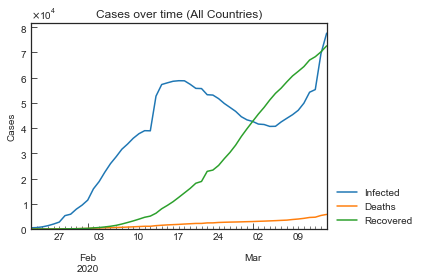

In [28]:
line_plot(total_df[data_cols], "Cases over time (All Countries)")

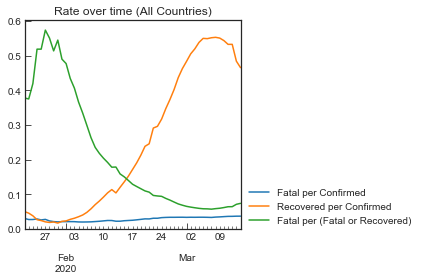

In [29]:
line_plot(total_df[rate_cols], "Rate over time (All Countries)", ylabel="", math_scale=False)

In [30]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,53.0,0.028532,0.005651,0.020408,0.022770,0.028054,0.034031,0.037278
Recovered per Confirmed,53.0,0.242817,0.206153,0.017365,0.045942,0.171758,0.465243,0.552602
Fatal per (Fatal or Recovered),53.0,0.212466,0.170815,0.057464,0.071430,0.129264,0.366071,0.573427


## Prediction with SIR-D Model

Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Hyperparameter Optimization

Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [39]:
%%time
sir_estimater = Estimater(
    SIR, covid_df, population_dict["Global"],
    name="All Countries")
sir_dict = sir_estimater.run()

CPU times: user 1min 13s, sys: 7.67 s, total: 1min 21s
Wall time: 1min 15s


In [31]:
%%time
sird_estimater = Estimater(
SIRD, covid_df, population_dict["Global"],
name="All Countries")
sird_dict = sird_estimater.run()

CPU times: user 1min 16s, sys: 7.57 s, total: 1min 24s
Wall time: 1min 18s


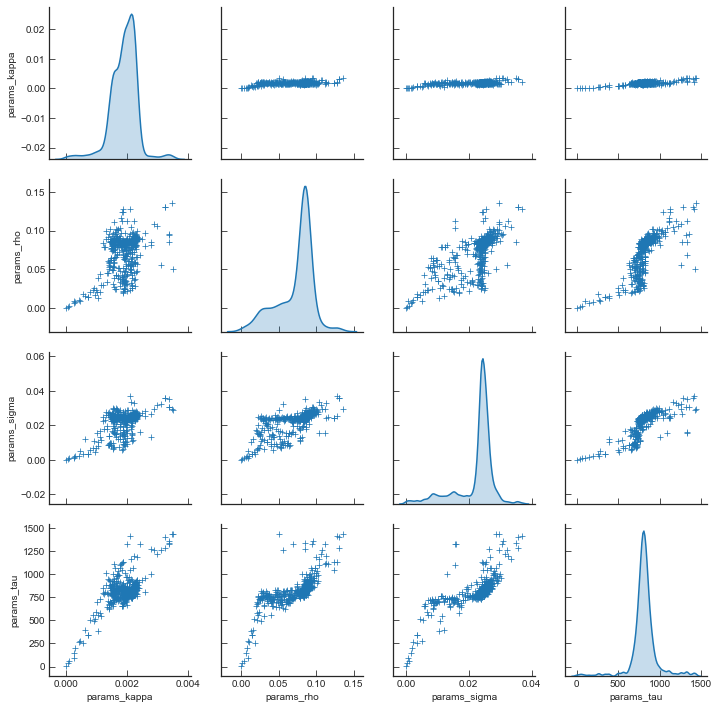

In [32]:
sird_estimater.history_graph()

In [40]:
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")

,tau,rho,sigma,R0,score,1/beta [day],1/gamma [day],kappa,1/alpha2 [day]
SIR,856,0.093751,0.030134,3.11,0.000009,6,19,-,-
SIR-D,789,0.088182,0.025877,3.13,0.000009,6,21,0.00225268,243


/Users/guest-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:140: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



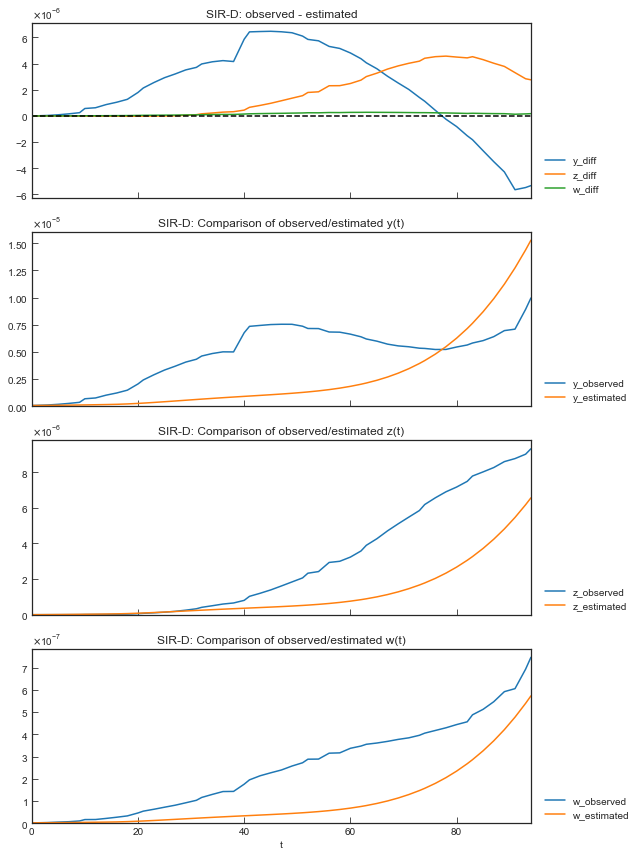

In [34]:
sird_estimater.compare_graph()

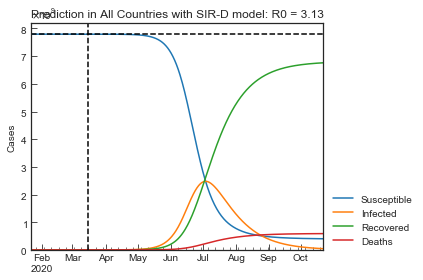

In [35]:
sird_estimater.predict_graph(step_n=500)